<a href="https://colab.research.google.com/github/ropatta/arquivo/blob/main/C%C3%B3pia_de_PSD_analise_forca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analise de força

na raiz devem estar os seguintes arquivos:
 - curvas/XXX_ViaN/pNN/arquivos de curva da porta pNN da medição de força feita na estação XXX via N
 - psd.py # biblioteca com funcoes para deteccao da curva
 - dados_jab_psd_peso.csv # dataset com as medicoes de forca
 - offset/offset.csv # arquivo com o offset das medicoes de corrente


 Os arquivos podem ser encontrados no endereço:
 http://10.21.241.130:8084/r323661/psd/-/tree/main/software/analise/forca_x_corrente
 (repositorio psd do git)

In [ ]:
!pip install mmq
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import importlib
import psd
from scipy.stats import pearsonr
from mmq import metodo_minimos_quadrados
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
importlib.reload(psd)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.style.use('classic')
pd.options.mode.chained_assignment = None

In [ ]:
def calcula_forca_media(df, extensao="csv"):
    '''calcula a forca media das medicoes feitas na estacao
    :param df: dataframe com as medicoes
    :param extensao: csv ou xls
    :return: dataframe com a forca media
    '''
    df['forca_media'] = round(df[['medida1', 'medida2', 'medida3']].mean(axis=1), 2)
    df['forca_std'] = round(df[['medida1', 'medida2', 'medida3']].std(axis=1), 2)
    df.to_csv("dados_jab_psd_peso.csv", sep=";",  index=False)
    return df

In [ ]:
def get_fechamento(curva):
    '''Retorna a curva de corrente do fechamento
    :param curva: curva de corrente
    :return: curva de corrente do fechamento
    '''
    valor = -2.5
    inicio_fechamento = curva[curva['corrente'] <= valor].index[0]
    curva = curva.iloc[inicio_fechamento-10:]
    tempo_inicial = curva['tempo'].iloc[0]
    curva['tempo'] = curva['tempo'] - tempo_inicial
    #curva.loc[curva.index[0], 'tempo'] = 0
    curva.reset_index(inplace=True)

    fim_fechamento = curva[curva['corrente'] > -0.6].index[0]
    curva = curva.iloc[:fim_fechamento]
    curva.reset_index(inplace=True)
    return curva

In [ ]:
def plota_curva(curva, arquivo, tempo = 1, frequencia = 0):
    '''Plota a curva
    :param curva: curva de corrente
    :param arquivo: nome do arquivo
    :param tempo: plotar curva de tempo
    :param frequencia: plotar curva de frequencia
    :return: None
    '''
    tamanho_janela = int(len(curva)/6)
    segmentos = psd.segmentar_sinal(curva, tamanho_janela)
    ft = psd.extrair_features_temporais(segmentos)
    ff = psd.extrair_features_frequenciais(segmentos)

    if(tempo):
        pp.plotar_curva(segmentos, ft, ff, title=f"{arquivo[:-4]}")
    if(frequencia):
        pp.plotar_fft(ff)

In [ ]:
def get_curva(path, plataforma="", porta=1, conversao = 1):
    '''Pega a curva
    :param path: caminho para a curva
    :param conversao: converter para corrente em A
    :return: curva de corrente
    '''
    offset = 12.00

    if plataforma != "":
        linha = plataforma[0]
        estacao = plataforma[1:-1]
        via = plataforma[-1]
        offset_csv = pd.read_csv(f"offset/offset-l0{linha}-{estacao}-mdl-psd-via{via}.csv", sep=";", header=None)
        offset_csv.columns = ['offset', 'modulo', 'canal']
        offset = offset_csv['offset'][porta-1]

    curva = pd.read_csv(path, sep=';')
    curva.rename(columns={curva.columns[0]: "tempo"}, inplace=True)
    curva.rename(columns={curva.columns[1]: "corrente"}, inplace=True)

    curva['tempo'] = curva['tempo']/1000000
    if(conversao):
        curva['corrente'] = (curva['corrente'] - offset)*2.5

    return curva

In [ ]:
def get_corrente_media(curva):
    '''Calcula a corrente media
    :param curva: curva de corrente
    :return: corrente media
    '''
    corrente_media = np.abs(round(curva['corrente'].mean(), 4))
    corrente_std = round(curva['corrente'].std(), 4)
    return "I_med", corrente_media, corrente_std

In [ ]:
def get_area(curva):
    '''Calcula a area
    :param curva: curva de corrente
    :return: area
    '''
    area = round(np.abs(np.trapz(y=curva['corrente'], x=curva['tempo'])), 4)
    return "A", area

In [ ]:
def get_potencia(curva):
    '''Calcula a potencia
    :param curva: curva de corrente
    :return: potencia
    '''
    potencia_media = np.abs(round(curva['corrente'].mean()*len(curva['tempo'])/1000, 4))
    potencia_std = round(curva['corrente'].std()*len(curva['tempo'])/1000, 4)
    return "P_med", potencia_media, potencia_std

In [ ]:
def get_coef_corr(forca, metrica, inverse = 0):
    '''Calcula o coeficiente de correlacao entre a forca e a metrica
    :param forca: forca
    :param metrica: metrica
    :param inverse: se for 1, inverte a metrica
    :return: coeficiente de correlacao
    '''

    # calcula o coeficiente de Pearson
    if inverse:
        corr, p_value = pearsonr(metrica, forca)
    else:
        corr, p_value = pearsonr(forca, metrica)
    corr = round(corr, 4)
    p_value = round(p_value, 5)

    # obtem a equacao linear obtida
    degree = 1
    if inverse:
        coef = metodo_minimos_quadrados.mmq(metrica, forca.to_numpy(), degree)
    else:
        coef = metodo_minimos_quadrados.mmq(forca.to_numpy(), metrica, degree)

    '''
    # outro metodo de eq linear

    #sm.add_constant(df['forca_media'].to_list())
    result = sm.OLS(df['forca_media'].to_list(), df['i_med'].to_list()).fit()
    # printing the summary table
    print(result.tvalues)
    '''

    x = np.linspace(0, 5, 10)
    y = coef[0] * x + coef[1]

    return {"corr": corr, "p_value": p_value, "coef": coef, "x": x, "y":y}


In [ ]:
def plot_analise(ax, forca_media, curva, segmentos, porta, medida, metricas, n_metricas = 1):
    '''Plota a analise de corrente
    :param ax: subplot
    :param forca_media: forca media
    :param curva: curva de corrente
    :param segmentos: segmentos da curva
    :param porta: porta
    :param medida: medida
    :param metricas: metricas
    :param n_metricas: numero de metricas
    :return: ax eixo com as plotagens
    '''

    legenda = ""

    for i in range(n_metricas):
        legenda += f" {metricas[i][0]} = {metricas[i][1]} |"
        #ax.hlines(y=metricas[i][1], xmin=curva['tempo'].iloc[0], xmax=curva['tempo'].iloc[-1], linestyles='dashed', color=colors[medida-5], linewidth=2)

    ax.plot(curva["tempo"], curva["corrente"],
                 label=f"P{porta} Força: {forca_media[medida-1]:.1f} N -  {legenda}", color=colors[medida-5])

    ax.set_xlabel('Tempo (s)')
    ax.set_ylabel('Corrente (A)')
    ax.set_ylim(-4, 1)
    ax.grid(True)
    ax.legend()

    return ax


In [ ]:
def plot_curvas(df_peso, curvas, porta):
    '''Plota as curvas de corrente
    :param df_peso: dataframe com as metricas
    :param curvas: curvas de corrente
    :param porta: porta
    :return: None
    '''
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    j = 0
    i = 0
    axes[0][0].set_ylabel("Corrente(A)")
    axes[1][0].set_ylabel("Corrente(A)")

    for curva in curvas:
        if(i == 5):
            i = 0
            j = 1

        if(j):
            axes[j][i].set_xlabel("Tempo(s)")

        corrente_media = round(curva['corrente'].mean(), 4)
        corrente_std = round(curva['corrente'].std(), 4)

        axes[j][i].text(0.1, 0.6, f"Força:{df_peso['forca_media'].iloc[i+(j*5)]:.1f}({df_peso['forca_std'].iloc[i+(j*5)]:.0f}) N")
        axes[j][i].text(0.1, 0.2, f"Corrente: {corrente_media} A")
        axes[j][i].plot(curva['tempo'], curva['corrente'])
        axes[j][i].set_title(f"Medida {i+1+(j*5)}", fontsize=12)
        axes[j][i].set_ylim(-4, 1)
        axes[j][i].set_xlim(0, 5)
        axes[j][i].grid(1)
        i += 1


In [ ]:
def plot_eq(ax, metricas, forca, porta=11, title="", scatter=0):
    '''Plota a equacao de cada porta
    :param ax: subplot
    :param metricas: metricas
    :param forca: forca
    :param porta: porta
    :param title: titulo
    :param scatter: se for 1, plota os pontos
    :return: ax eixo com as plotagens
    '''

    for metrica in metricas:
        legenda = f"Porta P{porta} - Corr: {metrica[2]['corr']} | Eq: f = {metrica[2]['coef'][1]:.3f} + {metrica[2]['coef'][0]:.3f}c"
        #print(metrica)
        if scatter:
            ax.scatter(metrica[1], forca, marker='o', color=colors[int(porta/10)], linewidth=2, linestyle='solid', label=legenda)
        else:
            ax.plot(metrica[1], forca, marker='o', color=colors[int(porta/10)], linewidth=2, linestyle='solid', label=legenda)

        ax.plot(metrica[2]['x'], metrica[2]['y'], color=colors[int(porta/10)])
    return ax

In [ ]:
def plot_eq_todos_dados(ax, metricas, forca, porta=11, title="", scatter=0):
    '''Plota a equacao de todos os dados
    :param ax: subplot
    :param metricas: metricas
    :param forca: forca
    :param porta: porta
    :param title: titulo
    :param scatter: se for 1, plota os pontos
    :return: ax eixo com as plotagens
    '''

    for metrica in metricas:
        legenda=f"Dados (todas as portas) - Corr: {metrica[2]['corr']}"
        if scatter:
            ax.scatter(metrica[1], forca, marker='o', color=colors[int(porta/10)], linewidth=2, linestyle='solid', label=legenda)
        else:
            ax.plot(metrica[1], forca, marker='o', color=colors[int(porta/10)], linewidth=2, linestyle='solid', label=legenda)

        ax.plot(metrica[2]['x'], metrica[2]['y'], color=colors[int(porta/10)], label=f"Eq. por MMQ (todos os dados): f = {metrica[2]['coef'][1]:.3f} + {metrica[2]['coef'][0]:.3f}c")
    return ax

In [ ]:
def normaliza(df, columns=["col1", "col2", "col3"], scaler=""):
    '''Normaliza as colunas
    :param df: dataframe
    :param columns: colunas a serem normalizadas
    :return: dataframe normalizado
    '''

    # Create the scaler object
    if scaler == "":
        scaler = MinMaxScaler()
    # Fit the scaler to the selected columns
    df[columns] = scaler.fit_transform(df[columns])

    return df, scaler

In [ ]:
def load_dataset(path, debug=1):
    '''Carrega o dataset
    :param path: caminho do dataset
    :param debug: se for 1, printa o dataset
    :return: dataframe com o dataset
    '''

    df = pd.read_csv(path, sep=';')
    # Select columns containing 'Unnamed'
    unnamed_cols = df.columns[df.columns.str.contains('Unnamed')]
    # Drop the selected columns
    df.drop(unnamed_cols, axis=1, inplace=True)

    row, col = df.shape
    print(f'Ha {row} linhas e {col} colunas no dataset completo')
    if debug:
        print(df.head(5))
    return df


In [ ]:
def calcula_erro(x, y, coef):
  '''Calcula o erro somado dos pontos para a reta obtida por mmq
  :param x: valores de x
  :param y: valores de y
  :param coef: coeficientes da reta
  :return: erro somado dos pontos
  '''
  erro = 0
  for i in range(len(x)):
    erro += (y[i] - (coef[0] * x[i] + coef[1]))**2
  return erro

  #sum((y_i - (m*x_i + b))^2)

In [ ]:
'''
calcula as metricas para todas as curvas de corrente
coloca os valores das metricas calculadas no arquivo de dados
'''

path_df = "dados_jab_psd_peso.csv"
print(f"[1] Carregando dataset: {path_df}\n")
df_forca = load_dataset(path_df, debug=1)
df_forca = calcula_forca_media(df_forca)
df_forca.sort_values(by=['forca_media'], inplace=True)
medidas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#df.drop(8, axis='index', inplace=True)

i_med = {}
a_med = {}
p_med = {}
std_med = []
curvas = []
metricas = {}
portas = [11, 31, 51]
portas_map = {11:1, 31:9, 51:17}
estacao = ["JAB1"]

print(f"\n\n[2] Calcula as metricas para as portas p{portas}\n")
for porta in portas:
    print(f" - calculando para a porta {porta}:")
    i_med[f"p{porta}"] = []
    a_med[f"p{porta}"] = []
    p_med[f"p{porta}"] = []
    for medida in medidas:
        arquivo = f"jab_p{porta}_medida{medida}.csv"
        path_curva = f"curvas/{estacao[0][:-1]}_Via{estacao[0][-1]}/p{porta}/{arquivo}"
        if not os.path.isfile(f"{path_curva}"):
            continue
        curva = get_curva(f"{path_curva}", plataforma="1jab1", porta=portas_map[porta])
        curva = get_fechamento(curva)
        curvas.append(curva)
        segmentos = psd.segmentar_sinal(curva, int(len(curva)/6))

        corrente_media = get_corrente_media(curva)
        i_med[f"p{porta}"].append(corrente_media[1])

        #potencia_media = get_potencia(curva)
        #p_med[f"p{porta}"].append(potencia_media[1])

        area = get_area(curva)
        a_med[f"p{porta}"].append(area[1])

        metricas[f"p{porta}"] = [corrente_media, area]

    #print(df_forca[df_forca[f"porta"] == f"p{porta}"])
    df_forca.loc[df_forca[f"porta"] == f"p{porta}", 'i_med'] = i_med[f"p{porta}"]
    #df_forca.loc[df_forca[f"porta"] == f"p{porta}", 'p_med'] = p_med[f"p{porta}"]
    df_forca.loc[df_forca[f"porta"] == f"p{porta}", 'a_med'] = a_med[f"p{porta}"]
    print(f" - - Feito")

print("\n\n[3] Novo dataset com as metricas calculadas\n")
row, col = df_forca.shape
print(f'Ha {row} linhas e {col} colunas no dataset ao final')
print(df_forca.head(5))
df_forca.to_csv(path_df, sep=";",  index=False)
print(f"\nArquivo {path_df} atualizado")

[1] Carregando dataset: dados_jab_psd_peso.csv

Ha 25 linhas e 9 colunas no dataset completo
  porta  medida1  medida2  medida3              csv  forca_media  forca_std  \
0   p51     47.3     49.2     47.6  jab_p51_medida1        48.03       1.02   
1   p51     51.8     52.0     51.8  jab_p51_medida2        51.87       0.12   
2   p51     55.8     55.4     56.0  jab_p51_medida3        55.73       0.31   
3   p11     59.8     55.6     55.2  jab_p11_medida1        56.87       2.55   
4   p31     55.0     58.8     60.4  jab_p31_medida1        58.07       2.77   

    i_med   a_med  
0  2.0511  5.5041  
1  2.1469  5.8148  
2  2.2189  6.1189  
3  1.8725  4.9495  
4  1.9640  5.2908  


[2] Calcula as metricas para as portas p[11, 31, 51]

 - calculando para a porta 11:
 - - Feito
 - calculando para a porta 31:
 - - Feito
 - calculando para a porta 51:
 - - Feito


[3] Novo dataset com as metricas calculadas

Ha 25 linhas e 9 colunas no dataset ao final
  porta  medida1  medida2  medida3    

[1] Carregando dataset: dados_jab_psd_peso.csv

Ha 25 linhas e 9 colunas no dataset completo


[2] Plota as curvas para as portas p[11, 31, 51]:

 - Plot das curvas da porta p11:


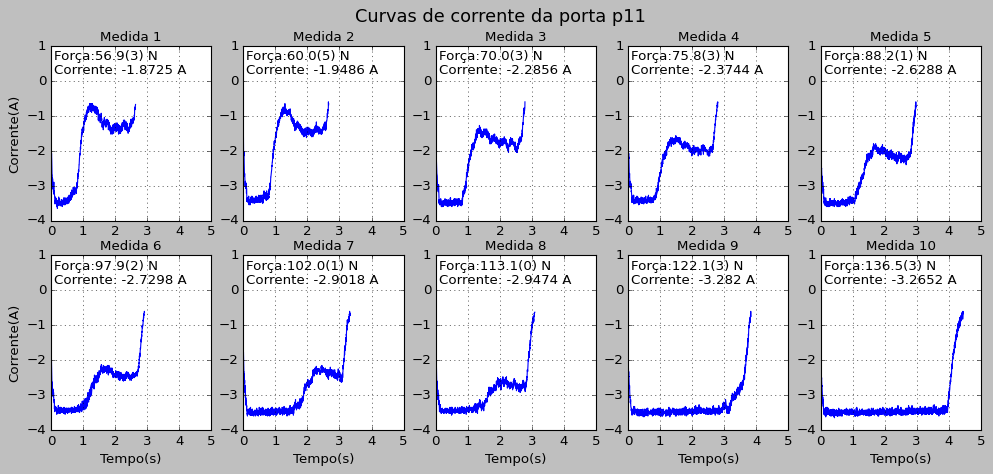


 - Plot das curvas da porta p31:


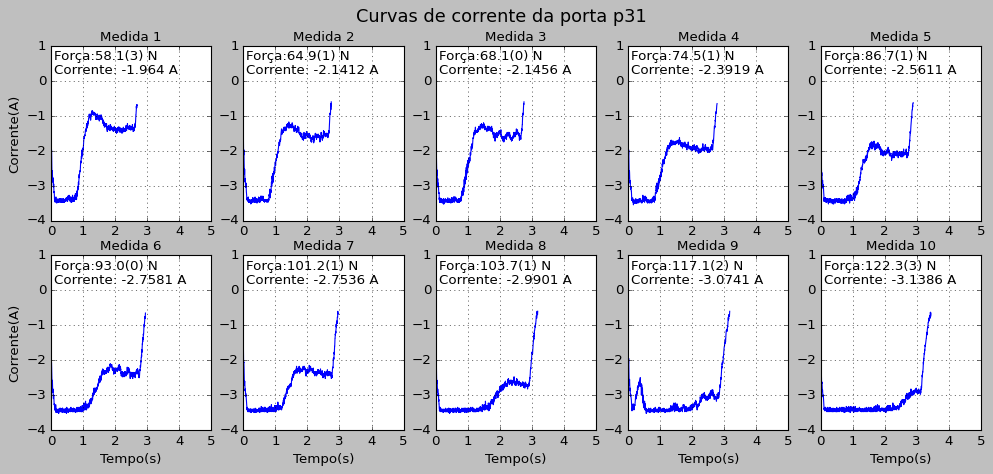


 - Plot das curvas da porta p51:


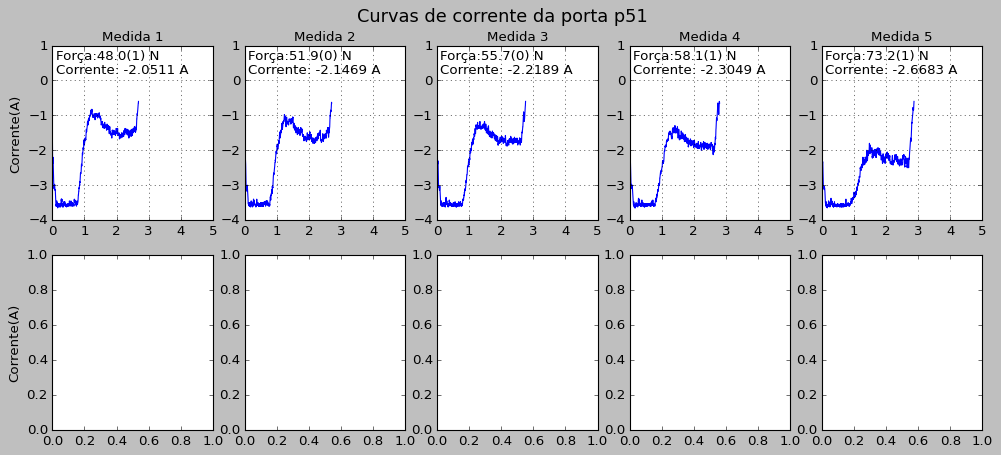

In [ ]:
'''
plota as curvas de corrente para todas as portas em figuras diferentes
'''

path_df = "dados_jab_psd_peso.csv"
print(f"[1] Carregando dataset: {path_df}\n")
df_forca = load_dataset(path_df, debug=0)

portas = [11, 31, 51]
portas_map = {11:1, 31:9, 51:17}
medidas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

print(f"\n\n[2] Plota as curvas para as portas p{portas}:")
for porta in portas:
    curvas = []
    for medida in medidas:
        arquivo = f"jab_p{porta}_medida{medida}.csv"
        path_curva = f"curvas/{estacao[0][:-1]}_Via{estacao[0][-1]}/p{porta}/{arquivo}"
        if not os.path.isfile(f"{path_curva}"):
            continue
        curva = get_curva(f"{path_curva}", plataforma="1jab1", porta=portas_map[porta])
        curva = get_fechamento(curva)
        curvas.append(curva)

    print(f"\n - Plot das curvas da porta p{porta}:")
    df_porta = df_forca[df_forca[f"porta"] == f"p{porta}"]
    plot_curvas(df_porta, curvas, porta)
    plt.suptitle(f"Curvas de corrente da porta p{porta}", fontsize=16)
    plt.show()

[1] Carregando dataset: dados_jab_psd_peso.csv

Ha 25 linhas e 9 colunas no dataset completo


[2] Plota as curvas para as portas p[11, 31, 51]:


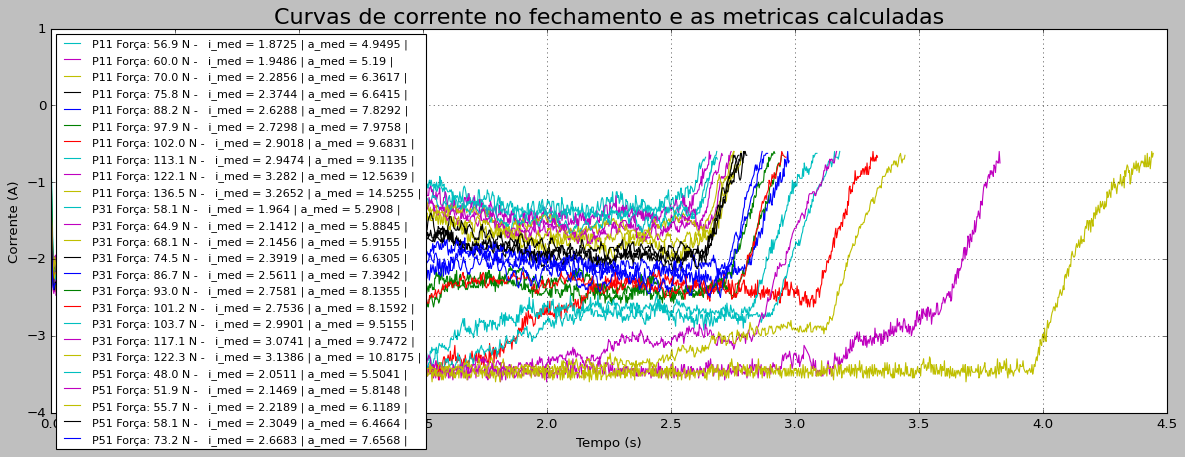

In [ ]:
'''
plota as curvas de corrente para todas as portas e suas metricas
'''

fig, ax = plt.subplots(1, 1, figsize=(18, 6))

path_df = "dados_jab_psd_peso.csv"
print(f"[1] Carregando dataset: {path_df}\n")
df_forca = load_dataset(path_df, debug=0)

portas = [11, 31, 51]
portas_map = {11:1, 31:9, 51:17}
medidas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#df.drop(x, axis='index', inplace=True)
curvas = []

print(f"\n\n[2] Plota as curvas para as portas p{portas}:")
for porta in portas:
    df_porta = df_forca[df_forca[f"porta"] == f"p{porta}"]
    df_porta.reset_index(inplace=True)
    for medida in medidas:
        arquivo = f"jab_p{porta}_medida{medida}.csv"
        path_curva = f"curvas/{estacao[0][:-1]}_Via{estacao[0][-1]}/p{porta}/{arquivo}"
        if not os.path.isfile(f"{path_curva}"):
            continue

        curva = get_curva(path_curva, plataforma="1jab1", porta=portas_map[porta])
        curva = get_fechamento(curva)
        curvas.append(curva)
        segmentos = psd.segmentar_sinal(curva, int(len(curva)/6))

        i_med = df_porta['i_med'].iloc[medida-1]
        a_med = df_porta['a_med'].iloc[medida-1]

        corrente_media = ["i_med", i_med]
        area = ["a_med", a_med]

        metricas = [corrente_media, area]
        #print(metricas)

        plot_analise(ax, df_porta['forca_media'], curva, segmentos, porta, medida, metricas, n_metricas=len(metricas))

plt.legend(loc=2, prop={'size': 10})
plt.title(f"Curvas de corrente no fechamento e as metricas calculadas", fontsize=20)
plt.show()

[1] Carregando dataset: dados_jab_psd_peso.csv

Ha 25 linhas e 9 colunas no dataset completo


[2] Calcula os coeficientes para as portas p[11, 31, 51]:
 - calculando para a porta 11:
 - - Feito
 - calculando para a porta 31:
 - - Feito
 - calculando para a porta 51:
 - - Feito
 - calcula a equacao media das portas p[11, 31, 51]


[3] Plota os dados de forca x corrente e a equacao media das portas p[11, 31, 51]


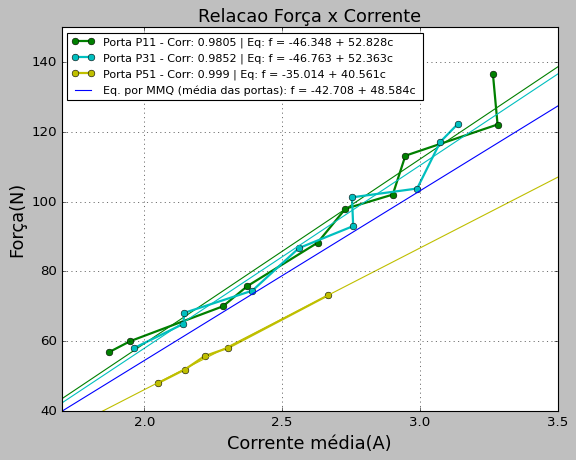

In [ ]:
'''
calcula os coeficientes para a equacao de cada porta
calcula a equacao media das portas
plota os dados de forca x corrente e a equacao de cada porta e a equacao media das portas
'''

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

path_df = "dados_jab_psd_peso.csv"
print(f"[1] Carregando dataset: {path_df}\n")
df_forca = load_dataset(path_df, debug=0)

#df_forca = normaliza(df_forca, columns=[f"i_med", f"p_med", f"a_med"])
#print(df_forca.head())

portas = [11, 31, 51]
portas_map = {11:1, 31:9, 51:17}

m = []
b = []

print(f"\n\n[2] Calcula os coeficientes para as portas p{portas}:")
for porta in portas:
    print(f" - calculando para a porta {porta}:")
    df_porta = df_forca[df_forca[f"porta"] == f"p{porta}"]
    i_med = df_porta['i_med']
    a_med = df_porta['a_med']

    metricas_corr = [["corrente", i_med]]
    metricas_corr[0].append(get_coef_corr(df_porta["forca_media"], np.array(i_med), inverse=1))
    #metricas_corr[1].append(get_coef_corr(df_porta["forca_media"], np.array(a_med)))

    ax = plot_eq(ax, metricas_corr, df_porta["forca_media"], porta)
    m.append(metricas_corr[0][2]['coef'][0])
    b.append(metricas_corr[0][2]['coef'][1])

    print(" - - Feito")

print(f" - calcula a equacao media das portas p{portas}")
# calcula os coeficientes da equacao media (media dos coeficientes da equacao de cada porta)
coef_ang = np.mean(m)
coef_lin = np.mean(b)
x = np.linspace(0, 5, 10)
y = coef_ang * x + coef_lin
ax.plot(x, y, label=f'Eq. por MMQ (média das portas): f = {coef_lin:.3f} + {coef_ang:.3f}c ')

print(f"\n\n[3] Plota os dados de forca x corrente e a equacao media das portas p{portas}")
plt.title(f"Relacao Força x Corrente", fontsize=16)
plt.ylabel("Força(N)", fontsize=16)
plt.xlabel("Corrente média(A)", fontsize=16)
plt.ylim(40, 150)
plt.xlim(1.7, 3.5)
plt.grid(1)
plt.legend(loc=2, prop={'size': 10})
plt.show()

[1] Carregando dataset: dados_jab_psd_peso.csv

Ha 25 linhas e 9 colunas no dataset completo


[2] Calcula os coeficientes para todos os dados
Erro da linha media: 1910
Erro da linha todos dados: 1358


[3] Plota os dados de forca x corrente e a equacao para todas as portas


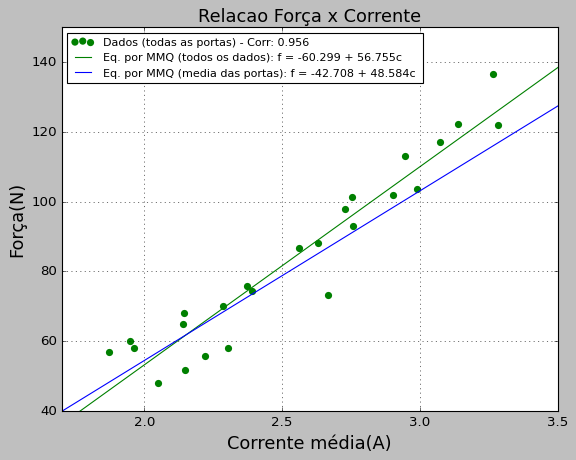

In [ ]:
'''
calcula os coeficientes para todos os dados
plota os dados de forca x corrente e a equacao para todos os dados
'''

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

path_df = "dados_jab_psd_peso.csv"
print(f"[1] Carregando dataset: {path_df}\n")
df_forca = load_dataset(path_df, debug=0)
#df_forca = normaliza(df_forca, columns=[f"i_med", f"p_med", f"a_med"])

i_med = df_forca['i_med']
a_med = df_forca['a_med']

print(f"\n\n[2] Calcula os coeficientes para todos os dados")
metricas_corr = [["corrente", i_med]]
metricas_corr[0].append(get_coef_corr(df_forca["forca_media"], np.array(i_med), inverse=1))
#metricas_corr[1].append(get_coef_corr(df_porta["forca_media"], np.array(a_med)))

ax = plot_eq_todos_dados(ax, metricas_corr, df_forca["forca_media"], scatter=1)
ax.plot(x, y, label=f'Eq. por MMQ (media das portas): f = {coef_lin:.3f} + {coef_ang:.3f}c ')

eixo_x = metricas_corr[0][1]
coef_lin_todos = metricas_corr[0][2]['coef'][1]
coef_ang_todos = metricas_corr[0][2]['coef'][0]
erro_linha_meida = calcula_erro(eixo_x, df_forca["forca_media"], [coef_ang, coef_lin])
erro_linha_todos = calcula_erro(eixo_x, df_forca["forca_media"], [coef_ang_todos, coef_lin_todos])
print(f"Erro da linha media: {erro_linha_meida:.0f}")
print(f"Erro da linha todos dados: {erro_linha_todos:.0f}")

print(f"\n\n[3] Plota os dados de forca x corrente e a equacao para todas as portas")
plt.title(f"Relacao Força x Corrente", fontsize=16)
plt.ylabel("Força(N)", fontsize=16)
plt.xlabel("Corrente média(A)", fontsize=16)
plt.xlim(1.7, 3.5)
plt.ylim(40, 150)
plt.grid(1)
plt.legend(loc=2, prop={'size': 10})
plt.show()